## Camera Calibration (6 marks)
----

In this section, we provide 40 images of 3D checkerboards from a video for camera calibration. You can find these images in the "data/camera_calib" folder. These frames contain two checkerboards with 20 mm and 40 mm grid sizes. Image 01\~14 is the checkerboard with a grid size of 40 mm, and image 15\~40 is the checkerboard with a grid size of 20 mm. The images are taken from different angles with different surroundings.    



The tasks you need to complete are:
* Choose **one image** for the calibration and explain why you choose it. (2 marks)
* After the chosen, please use this image to calibrate the camera, which needs to calculate the intrinsic matrix $\mathbf{K}$, rotation matrix $\mathbf{R}$, and translation vector $\mathbf{t}$. (4 marks)

#### The camera calibration process:
---
1. Detect keypoints of the checkerboard
2. Fix the world coordinate and get the corresponding keypoints world coordinate. **Please fix the world coordinate as a right-handed coordinate and z-axis up (example as follow)**

<table>
<td> 
<img src='./data/checkerboard/checkerboard_1.png' style='zoom:50%' ><br>
</td> 
<td> 
<img src='./data/checkerboard/checkerboard_2.png' style='zoom:50%' > 
</td> 
</table>
<caption><center> Figure 1: two checkerboards and the world coordinates</center></caption>

3. Generate equations with 3D-2D matching pair
4. Solve projection matrix $\mathbf{P}$ with equations
5. Decompose $\mathbf{K}$,$\mathbf{R}$, $\mathbf{t}$ from $\mathbf{P}$

Please follow the steps and complete the camera calibration using the image you have chosen.


### Task 1 : Choose **one image** for the calibration and explain why you choose it. (2 marks)
----
Please type your answer here 


The calibration board I choose is 30. I choose it because it is not blocked by any obstacle, and the entire calibration board is shown in the image and it is clear. The checkerboard length of the board I choose is 20mm, as more key points can be detected from it, and coordinates of key points can be detected more precisely.


### Task 2 : Calculate the intrinsic matrix $\mathbf{K}$, rotation matrix $\mathbf{R}$, and translation vector $\mathbf{t}$. (4 marks)
----
please code below to calculate the required parameters and enter your final result of $\mathbf{K}$, $\mathbf{R}$, $\mathbf{t}$ here
...

Tips: Tutorial 1 can be the reference. 

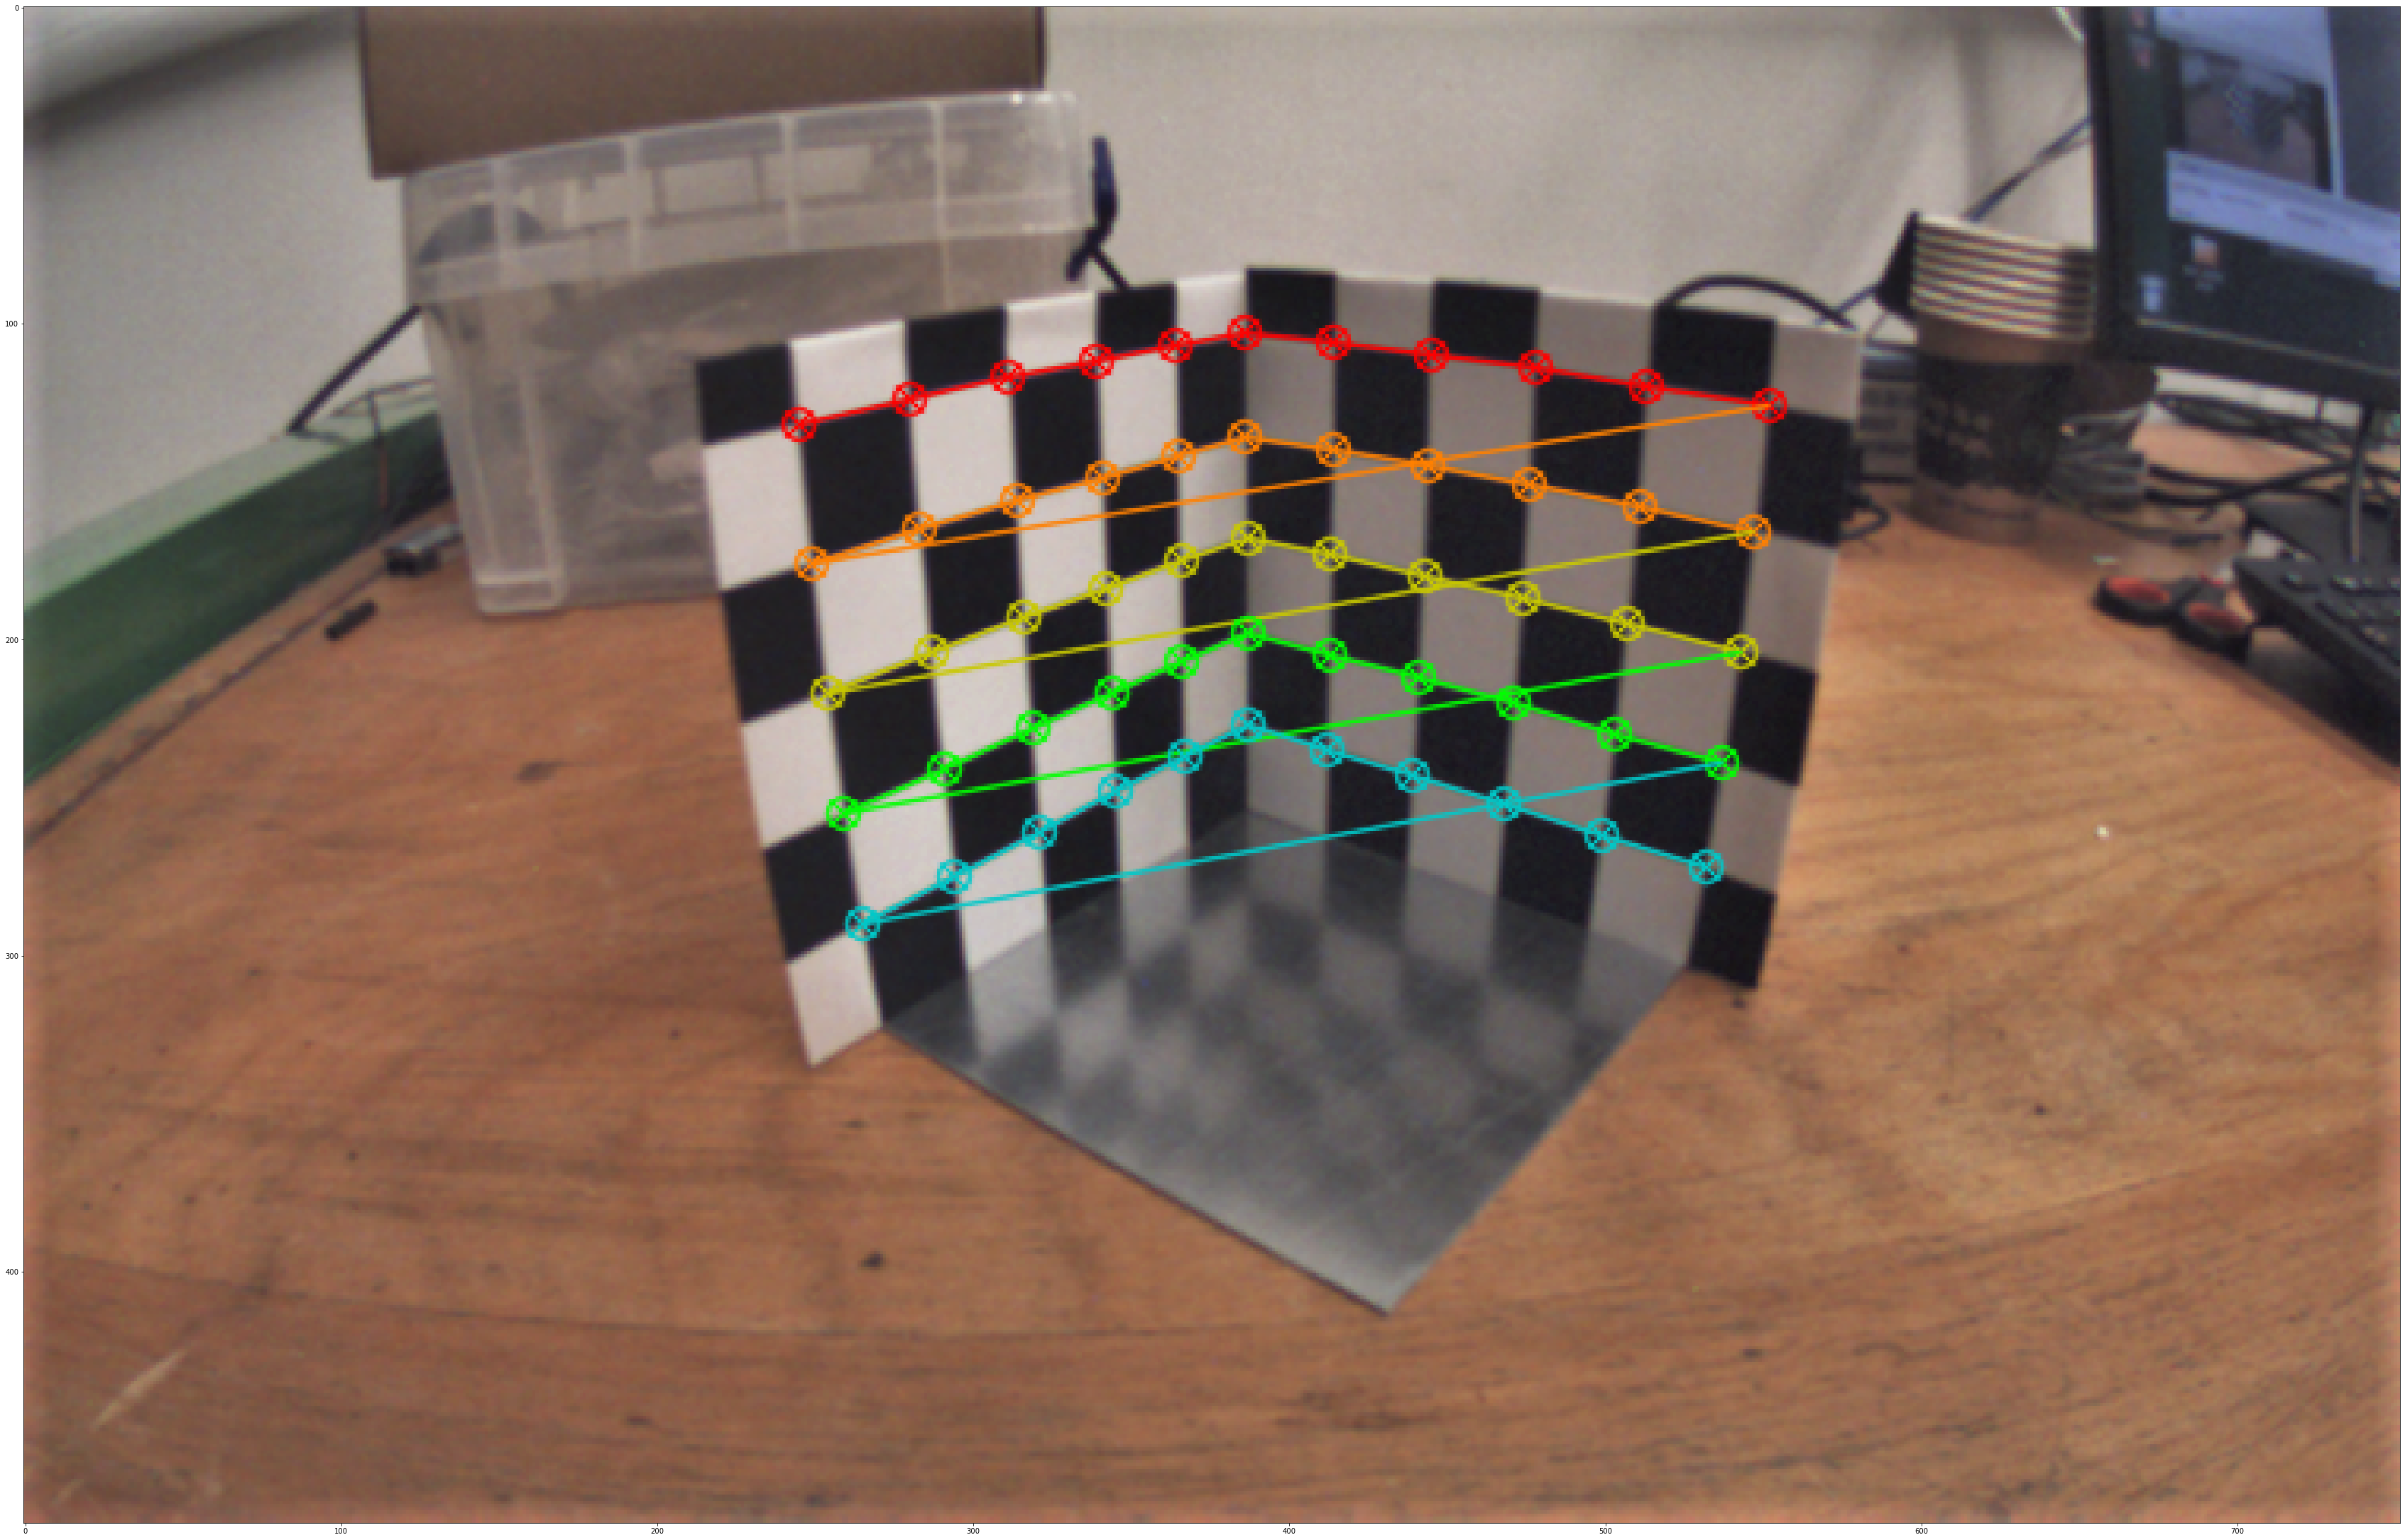

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img=cv2.imread("data/camera_calib/30.png", cv2.IMREAD_COLOR)   # load the image you choose
checkerboard_size=(11,5)   # Number of inner corners per a chessboard row/column, which will be use in cv2.findChessboardCorners()
checkerboard_length= 20    # the board grid size you choose
img_points = []

def detect_keypoints(img, checkboard_size):
    
    ret,corners=cv2.findChessboardCorners(img,checkerboard_size,flags = cv2.CALIB_CB_ADAPTIVE_THRESH)
    
    
    if ret==True:
        criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 3, 0.1) # stop after 3 iterations or the accuracy of 0.1 is achieved
        img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        corners2=cv2.cornerSubPix(img_gray,corners,(5,5),(-1,-1),criteria) 
        img_points.append(corners2)

    img_corner=cv2.drawChessboardCorners(img,checkerboard_size,corners2,ret) # draw detected corners
    img_corner2 = img_corner[:,:,::-1] 	# transform image from bgr to rgb
    plt.figure(figsize=(60,60))
    plt.imshow(img_corner2)
    plt.show()
    
    return np.reshape(img_points, (-1, 2))

key_points = detect_keypoints(img, checkerboard_size)



In [2]:
def fix_world_points(checkerboard_size,checkerboard_length):
    # fix the world coordinate and get cooresponding keypoints in the world coordinates
    num_h=checkerboard_size[0]
    num_v=checkerboard_size[1]
    objp = []

    for i in range(num_v):
        for j in range(num_h):
            if j<6:
                # objp_point=[0,(5-j)*checkerboard_length,(5-i)*checkerboard_length]
                objp_point=[(5-j)*checkerboard_length,0,(5-i)*checkerboard_length]
                objp.append(objp_point)
            else:
                # objp_point=[(j-5)*checkerboard_length,0,(5-i)*checkerboard_length]
                objp_point=[0,(j-5)*checkerboard_length,(5-i)*checkerboard_length]
                objp.append(objp_point)


    return np.reshape(np.array(objp), (-1, 3))


world_points=fix_world_points(checkerboard_size,checkerboard_length)
world_points

array([[100,   0, 100],
       [ 80,   0, 100],
       [ 60,   0, 100],
       [ 40,   0, 100],
       [ 20,   0, 100],
       [  0,   0, 100],
       [  0,  20, 100],
       [  0,  40, 100],
       [  0,  60, 100],
       [  0,  80, 100],
       [  0, 100, 100],
       [100,   0,  80],
       [ 80,   0,  80],
       [ 60,   0,  80],
       [ 40,   0,  80],
       [ 20,   0,  80],
       [  0,   0,  80],
       [  0,  20,  80],
       [  0,  40,  80],
       [  0,  60,  80],
       [  0,  80,  80],
       [  0, 100,  80],
       [100,   0,  60],
       [ 80,   0,  60],
       [ 60,   0,  60],
       [ 40,   0,  60],
       [ 20,   0,  60],
       [  0,   0,  60],
       [  0,  20,  60],
       [  0,  40,  60],
       [  0,  60,  60],
       [  0,  80,  60],
       [  0, 100,  60],
       [100,   0,  40],
       [ 80,   0,  40],
       [ 60,   0,  40],
       [ 40,   0,  40],
       [ 20,   0,  40],
       [  0,   0,  40],
       [  0,  20,  40],
       [  0,  40,  40],
       [  0,  60

In [3]:
def coefficients_from_3d_2d(image: np.ndarray, world: np.ndarray):
    """Get coefficients for the polynomial equation.

    Args:
        image (np.ndarray): 2D vector (u, v).
        world (np.ndarray): 3D vector (x, y, z).

    Returns:
        np.ndarray: Coefficients of 2 rows of A (2x12).
    """
    # P = [p11 p12 p13 p14 p21 p22 p23 p24 p31 p32 p33 p34]
    res = np.zeros((2, 12))

    # ----------your code goes here-------------
    u,v = image
    x,z,y = world
    
    # p1 * X - u * p * X = 0
    res[0][0] = -x
    res[0][1] = -y
    res[0][2] = -z
    res[0][3] = -1
    res[0][4] = 0
    res[0][5] = 0
    res[0][6] = 0
    res[0][7] = 0
    res[0][8] = u*x
    res[0][9] = u*y
    res[0][10] = u*z
    res[0][11] = u
    
    # p2 * X - v * p3 * X = 0
    res[1][0] = 0
    res[1][1] = 0
    res[1][2] = 0
    res[1][3] = 0
    res[1][4] = -x
    res[1][5] = -y
    res[1][6] = -z
    res[1][7] = -1
    res[1][8] = v*x
    res[1][9] = v*y
    res[1][10] = v*z
    res[1][11] = v
    
    
    return res


def solve_P(A: np.ndarray):
    """Solve for P using A.

    Args:
        A (np.ndarray): Matrix A (2N, 12).

    Returns:
        np.ndarray: Matrix P (3x4).
    """
    
    #     for SVD, you can use np.linalg.svd()
    # ----------your code goes here-------------
    _,_,V = np.linalg.svd(A)
    P = V[-1].reshape(3,4)
    
    return P


def decompose_P(P: np.ndarray):
    """Decompose P into K, R, t.

    Args:
        P (np.ndarray): Matrix P (3x4).

    Returns:
        K (np.ndarray): Matrix K (3x3).
        R (np.ndarray): Matrix R (3x3).
        t (np.ndarray): Matrix t (3x1).
    """
    
    KR = P[:, :3]
    KKT = KR @ KR.T  # KKT = KR @ KR.T = K @ K.T
    norm=KKT[2, 2] 
    KKT /= norm
    sign = P[0][3] / np.abs(P[0][3])
    P /= np.sqrt(norm) * sign
    KR = P[:, :3]
    Kt = P[:, 3]

    u0 = KKT[0][2]
    v0 = KKT[1][2]
    fy = np.sqrt(KKT[1][1] - v0 ** 2)
    s = (KKT[0][1] - u0 * v0) / fy
    fx = np.sqrt(KKT[0][0] - u0 ** 2 - s ** 2)
    K = np.array([[fx, s, u0], [0, fy, v0], [0, 0, 1]])
    R = np.linalg.inv(K) @ KR  # R = K^-1 @ KR
    t = np.linalg.inv(K) @ Kt  # t = K^-1 @ Kt
    
    return K, R, t


def calibrate_3d_2d(image_points: np.ndarray, world_points: np.ndarray):
    """Calibrate 3D to 2D.

    Args:
        image_points (np.ndarray): 2D points (N, 2).
        world_points (np.ndarray): 3D points (N, 3).

    Returns:
        K (np.ndarray): Matrix K (3x3).
        R (np.ndarray): Matrix R (3x3).
        t (np.ndarray): Matrix t (3x1).
    """
    
    A = np.zeros((2 * image_points.shape[0], 12))
    for i in range(image_points.shape[0]):
        A[2 * i: 2 * i +
            2] = coefficients_from_3d_2d(image_points[i], world_points[i])
    P = solve_P(A)
    K, R, t = decompose_P(P)
    return K, R, t



K, R, t = calibrate_3d_2d(key_points, world_points)
print(K)
print(R)
print(t)



[[493.65656727   1.84776638 406.06310005]
 [  0.         490.13564914 228.56773635]
 [  0.           0.           1.        ]]
[[-0.58690125  0.01385369  0.80953999]
 [ 0.32203533 -0.91336871  0.24910006]
 [-0.74285945 -0.40689761 -0.53159587]]
[-12.55437005  17.0139042  328.13314844]
